In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [2]:
import re
mjasto = 'kolobrzeg'

with open(f'{mjasto}.txt', 'r', encoding='ISO-8859-2') as file:
    lines = file.readlines()[1:5000]

data = [re.split(r'\s+', line.strip()) for line in lines]

columns = [
    'N', 'M', 'D', 'H', 'DBT', 'RH', 'HR', 'WS', 'WD',
    'ITH', 'IDH', 'ISH', 'TSKY',
    'N_0', 'N_30', 'NE_30', 'E_30', 'SE_30', 'S_30', 'SW_30', 'W_30', 'NW_30',
    'N_45', 'NE_45', 'E_45', 'SE_45', 'S_45', 'SW_45', 'W_45', 'NW_45',
    'N_60', 'NE_60', 'E_60', 'SE_60', 'S_60', 'SW_60', 'W_60', 'NW_60',
    'N_90', 'NE_90', 'E_90', 'SE_90', 'S_90', 'SW_90', 'W_90', 'NW_90'
]

df = pd.DataFrame(data, columns=columns)
df = df.drop(index=0)
df = df.apply(pd.to_numeric, errors='coerce')

def calculate_date(row):
    total_hours = row['N'] - 1
    remaining_hours = total_hours % 8760

    days_passed = remaining_hours // 24
    hour = row['H']

    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    month = 0
    while days_passed >= month_days[month]:
        days_passed -= month_days[month]
        month += 1

    day = days_passed + 1
    return pd.Timestamp(year=1992, month=int(month) + 1, day=int(day), hour=int(hour))

df['date'] = df.apply(calculate_date, axis=1)

df.set_index('date', inplace=True)

In [3]:
df.sample(5)

,N,M,D,H,DBT,RH,HR,WS,WD,ITH,...,W_60,NW_60,N_90,NE_90,E_90,SE_90,S_90,SW_90,W_90,NW_90
date,,,,,,,,,,,,,,,,,,,,,
1992-02-10 05:00:00,966,2,10,5,2.8,87,4.097,3.0,19,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-01-28 12:00:00,661,1,28,12,2.0,82,3.609,5.0,14,145.4,...,146.4,130.8,130.8,130.8,130.8,157.1,177.6,170.7,140.4,130.8
1992-06-04 18:00:00,3715,6,4,18,21.0,52,8.034,1.0,7,52.3,...,52.3,52.3,52.3,52.3,52.3,52.3,52.3,52.3,52.3,52.3
1992-07-09 04:00:00,4541,7,9,4,12.5,92,8.361,2.0,16,34.9,...,34.9,34.9,34.9,34.9,34.9,34.9,34.9,34.9,34.9,34.9
1992-07-21 09:00:00,4834,7,21,9,14.0,78,7.827,6.0,22,409.4,...,340.5,340.5,340.5,342.1,382.9,398.9,380.6,340.5,340.5,340.5


In [4]:
selected_columns = ['DBT', 'RH', 'HR', 'WS', 'WD', 'ITH', 'IDH', 'ISH', 'TSKY']
n_hours = 24
df_selected = df[selected_columns][:-n_hours]

In [5]:
import csv

def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

for column in selected_columns:
    print(f'Testing {column} for stationarity:')
    test_stationarity(df_selected[column])

df_selected_diff = df_selected.diff().dropna()

model = VAR(df_selected_diff)
lag_order = model.select_order(maxlags=50)
print(lag_order.summary())
model_fitted = model.fit(lag_order.aic)

print(model_fitted.summary())

last_values = df_selected_diff.values[-model_fitted.k_ar:]

forecast_diff = model_fitted.forecast(last_values, steps=n_hours)

forecast_index = pd.date_range(start=df_selected.index[-1] + pd.Timedelta(hours=1), periods=n_hours, freq='h')
forecast_df = pd.DataFrame(forecast_diff, index=forecast_index, columns=df_selected.columns)

forecast_level = forecast_df.cumsum() + df_selected.iloc[-1]

print(forecast_level)

Testing DBT for stationarity:
ADF Statistic: -2.3798616504235204
p-value: 0.1475011623297275
Critical Values:
	1%: -3.4316738971778435
	5%: -2.8621250178829576
	10%: -2.567081405988135
Testing RH for stationarity:
ADF Statistic: -8.758360293312359
p-value: 2.716343757297851e-14
Critical Values:
	1%: -3.431674165258379
	5%: -2.8621251363188898
	10%: -2.5670814690363084
Testing HR for stationarity:
ADF Statistic: -2.3023860016724056
p-value: 0.1711995932474153
Critical Values:
	1%: -3.4316738971778435
	5%: -2.8621250178829576
	10%: -2.567081405988135
Testing WS for stationarity:
ADF Statistic: -9.156776733047598
p-value: 2.596998904244363e-15
Critical Values:
	1%: -3.431674165258379
	5%: -2.8621251363188898
	10%: -2.5670814690363084
Testing WD for stationarity:
ADF Statistic: -8.03228218397604
p-value: 1.943878595138951e-12
Critical Values:
	1%: -3.4316725584017265
	5%: -2.8621244264217403
	10%: -2.5670810911297512
Testing ITH for stationarity:
ADF Statistic: -5.457479718385769
p-value: 

I:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        4.892       4.904       133.2       4.896
1        2.114       2.233       8.280       2.156
2        1.864       2.090       6.448       1.943
3        1.539       1.871       4.658       1.655
4        1.320       1.760       3.742       1.474
5        1.215       1.762       3.370       1.407
6        1.081      1.734*       2.947       1.310
7       0.9800       1.741       2.665       1.247
8       0.9390       1.807       2.557       1.243
9       0.8640       1.839       2.373       1.206
10      0.8213       1.903       2.274       1.201
11      0.7909       1.979       2.205       1.208
12      0.7348       2.030       2.085       1.189
13      0.6724       2.075       1.959       1.164
14      0.6361       2.146       1.889       1.166
15      0.5819       2.198       1.790       1.149
16      0.4989       2.222     

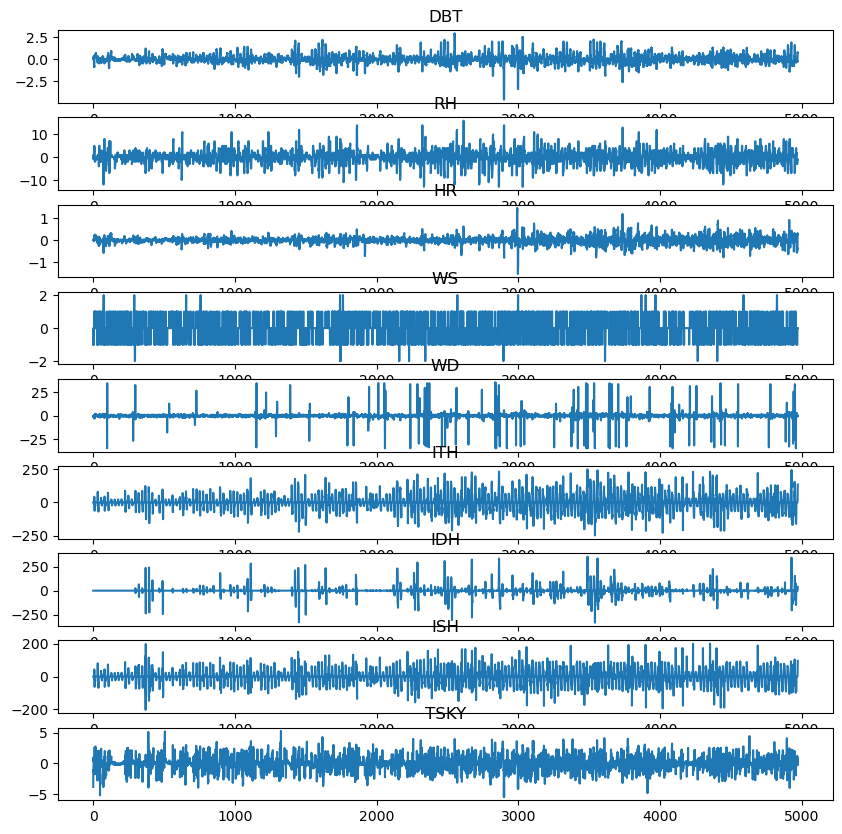

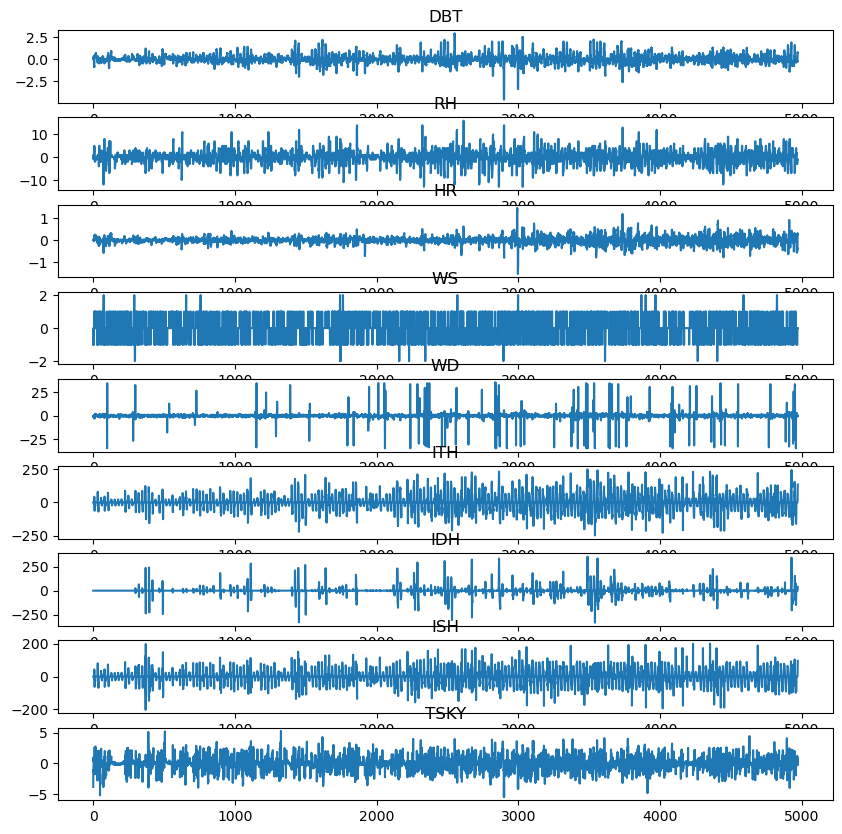

In [6]:
model_fitted.plot()

In [7]:
common_index = df_selected.index.intersection(forecast_level.index)
actual_values = pd.DataFrame(df[-n_hours:])
predicted_values = pd.DataFrame(forecast_level)
print(actual_values['DBT'])
print(predicted_values['DBT'])

date
1992-07-27 06:00:00    18.2
1992-07-27 07:00:00    20.7
1992-07-27 08:00:00    23.3
1992-07-27 09:00:00    25.8
1992-07-27 10:00:00    26.8
1992-07-27 11:00:00    27.7
1992-07-27 12:00:00    28.7
1992-07-27 13:00:00    26.4
1992-07-27 14:00:00    24.1
1992-07-27 15:00:00    21.8
1992-07-27 16:00:00    20.7
1992-07-27 17:00:00    19.7
1992-07-27 18:00:00    18.6
1992-07-27 19:00:00    18.3
1992-07-27 20:00:00    18.1
1992-07-27 21:00:00    17.8
1992-07-27 22:00:00    17.4
1992-07-27 23:00:00    17.1
1992-07-28 00:00:00    16.7
1992-07-28 01:00:00    16.8
1992-07-28 02:00:00    16.9
1992-07-28 03:00:00    17.0
1992-07-28 04:00:00    17.2
1992-07-28 05:00:00    17.5
Name: DBT, dtype: float64
1992-07-27 06:00:00    18.320187
1992-07-27 07:00:00    19.490481
1992-07-27 08:00:00    20.791848
1992-07-27 09:00:00    21.954286
1992-07-27 10:00:00    22.450469
1992-07-27 11:00:00    22.961456
1992-07-27 12:00:00    23.403757
1992-07-27 13:00:00    23.140513
1992-07-27 14:00:00    22.769317


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

error_metrics = {
    'Column': [],
    'MSE': [],
    'MAE': [],
    'R2': []
}

for column in selected_columns:
    mse = mean_squared_error(actual_values[column], predicted_values[column])
    mae = mean_absolute_error(actual_values[column], predicted_values[column])
    r2 = r2_score(actual_values[column], predicted_values[column])

    error_metrics['Column'].append(column)
    error_metrics['MSE'].append(mse)
    error_metrics['MAE'].append(mae)
    error_metrics['R2'].append(r2)

error_metrics_df = pd.DataFrame(error_metrics)
error_metrics_df.to_csv('model_summary.csv')

print(error_metrics_df)

  Column           MSE         MAE        R2
0    DBT      4.791269    1.552129  0.685818
1     RH    127.976947   10.244231  0.669968
2     HR      1.477911    1.069232 -1.329995
3     WS      2.108396    1.294738  0.156055
4     WD    130.473261   10.630963 -0.060279
5    ITH   8602.910746   67.683716  0.918201
6    IDH  32323.880061  111.516991  0.550590
7    ISH   9158.385263   63.844712 -0.044441
8   TSKY     26.629532    4.344703 -4.085150


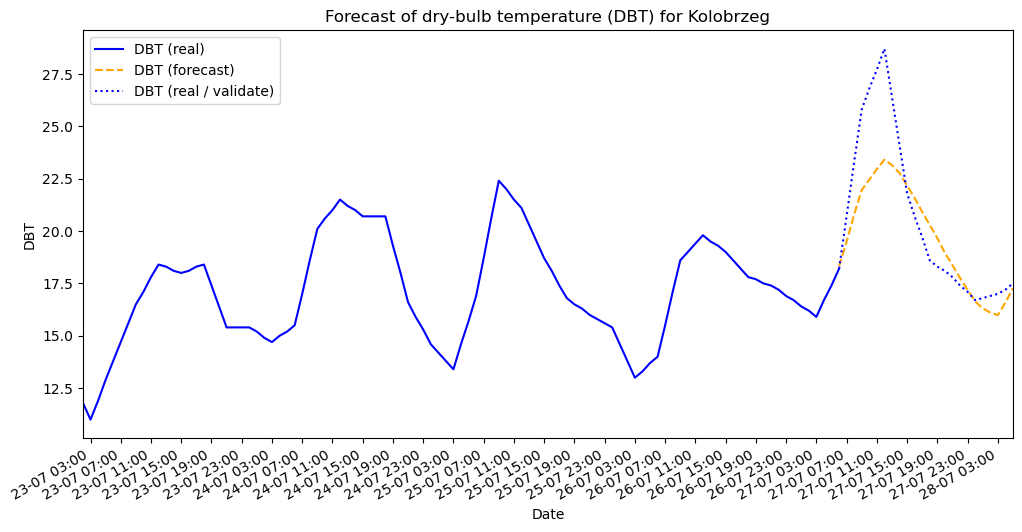

In [9]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index[-100 - n_hours:-n_hours+1], df['DBT'].values[-100 - n_hours:-n_hours+1], label='DBT (real)', color='blue')
plt.plot(forecast_level.index, forecast_level['DBT'], label='DBT (forecast)', color='orange', linestyle='--')
plt.plot(df.index[-n_hours:], df['DBT'].values[-n_hours:], label='DBT (real / validate)', color='blue', linestyle=':')

plt.xlim(df.index[-100 - n_hours], df.index[-1])

plt.title(f'Forecast of dry-bulb temperature (DBT) for {mjasto.capitalize()}')
plt.xlabel('Date')
plt.ylabel('DBT')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.legend()
plt.gcf().autofmt_xdate()
plt.savefig(f'{mjasto}_DBT.pdf')
plt.show()

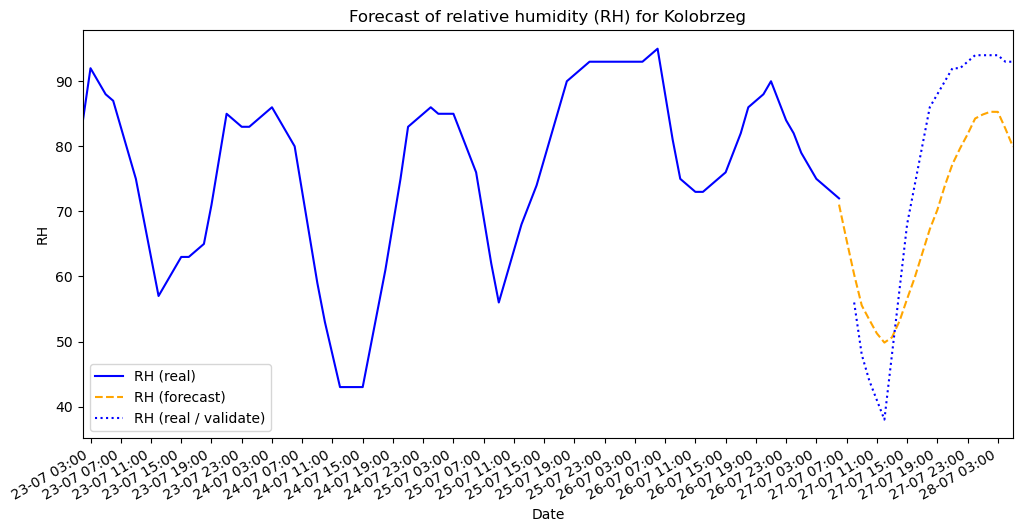

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100 - n_hours:-n_hours+1], df['RH'].values[-100 - n_hours:-n_hours+1], label='RH (real)', color='blue')
plt.plot(forecast_level.index, forecast_level['RH'], label='RH (forecast)', color='orange', linestyle='--')
plt.plot(df.index[-n_hours+2:], df['RH'].values[-n_hours+2:], label='RH (real / validate)', color='blue', linestyle=':')

plt.xlim(df.index[-100 - n_hours], df.index[-1])

plt.title(f'Forecast of relative humidity (RH) for {mjasto.capitalize()}')
plt.xlabel('Date')
plt.ylabel('RH')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.legend()
plt.gcf().autofmt_xdate()
plt.savefig(f'{mjasto}_RH.pdf')
plt.show()

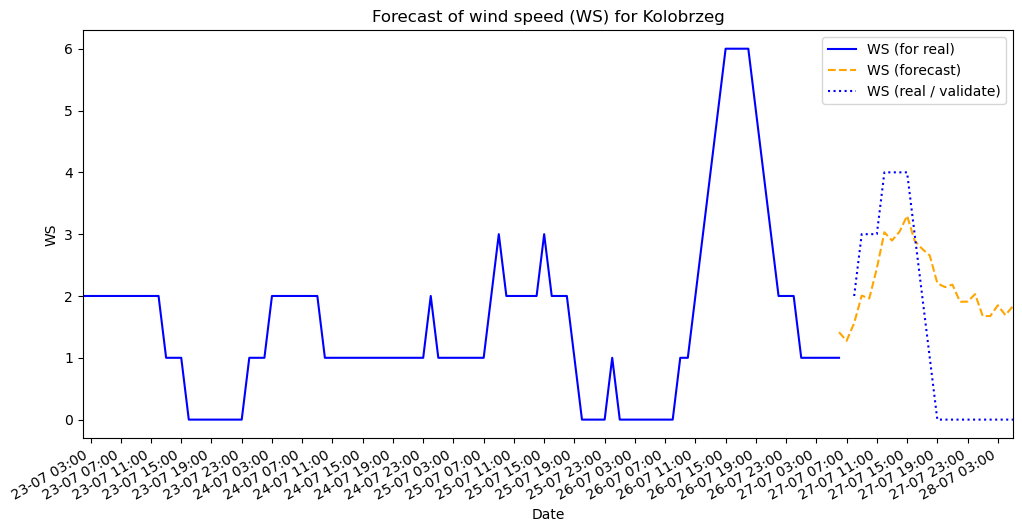

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100 - n_hours:-n_hours+1], df['WS'].values[-100 - n_hours:-n_hours+1], label='WS (for real)', color='blue')
plt.plot(forecast_level.index, forecast_level['WS'], label='WS (forecast)', color='orange', linestyle='--')
plt.plot(df.index[-n_hours+2:], df['WS'].values[-n_hours+2:], label='WS (real / validate)', color='blue', linestyle=':')

plt.xlim(df.index[-100 - n_hours], df.index[-1])

plt.title(f'Forecast of wind speed (WS) for {mjasto.capitalize()}')
plt.xlabel('Date')
plt.ylabel('WS')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.legend()
plt.gcf().autofmt_xdate()
plt.savefig(f'{mjasto}_WS.pdf')
plt.show()